<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Image pre-processing</h2>
</div>

In [1]:
import os
import string
import random 
import sys
import numpy as np
import random 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
from PIL import Image
import man_augmentation as aug
import albumentations as alb

# Get top level modules 
sys.path.append('..')
from src.engine import get_rand_name
from src.engine import color_img

%matplotlib inline

sns.set(rc={'figure.figsize':(8,6)})
sns.set_context('talk')
sns.set_style('darkgrid', {'font.sans-serif': ['Bahnschrift']})

In [ ]:
ROOT = "../input/"

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Preprocess the <a href="https://github.com/MarcWong/UDD">UDD</a> dataset - shift the label numbering</h2>
</div>

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">


<table style="width:40%" align="left">
  <tr align="center">
    <th>UDD Label</th>
    <th>UDD Numbering</th>
    <th>Our Label</th>
    <th>Our Numbering</th>
    <th>Output Mask Color</th>
  </tr>
  <tr align="center">
    <td>Vegetation</td>
    <td>0</td>
    <td>Vegetation</td>
    <td>3</td>
    <td>rgb(0,255,0)</td>
  </tr>
  <tr align="center">
    <td>Building</td>
    <td>1</td>
    <td>Background</td>
    <td>0</td>
    <td>rgb(0,0,0)</td>
  </tr>
  <tr align="center">
    <td>Road</td>
    <td>2</td>
    <td>Road</td>
    <td>1</td>
    <td>rgb(0,0,255)</td>
  </tr>
  <tr align="center">
    <td>Vehicle</td>
    <td>3</td>
    <td>Occlusion</td>
    <td>2</td>
    <td>rgb(128,128,0)</td>
  </tr>
  <tr align="center">
    <td>Other</td>
    <td>4</td>
    <td>Background</td>
    <td>0</td>
    <td>rgb(0,0,0)</td>
  </tr>
</table>
    
</div>

In [ ]:
val = [3, 0, 1, 2, 0]
for (i, fname) in enumerate(os.listdir('source-dataset-udd/val/src/')):
    frame_in = cv2.imread('source-dataset-udd/val/src/' + fname)
    mask_in = cv2.imread('source-dataset-udd/val/gt/' + fname.split(".")[0] + '.png')
    mask = np.zeros((mask_in.shape[0], mask_in.shape[1]), dtype=np.uint8)

    for j in range(len(val)):
        mask += (mask_in[:, :, 0] == j).astype('uint8') * val[j]

    cv2.imwrite('source-dataset-udd/validation/images/' + fname.split(".")[0] + '.png', frame_in)
    cv2.imwrite('source-dataset-udd/validation/mask/' + fname.split(".")[0] + '.png', mask)

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Slice image of window (256 x 256)</h2>
</div>

In [ ]:
# frame_in_path = 'source-dataset-nit/generated-v2-02/JPEGImages/'
# mask_in_path = 'source-dataset-nit/generated-v2-02/SegmentationClass/'
frame_in_path = 'source-dataset-nit/generated-v6-Tanmay/JPEGImages/'
mask_in_path = 'source-dataset-nit/generated-v6-Tanmay/SegmentationClass/'
frame_out_path = 'source-dataset-nit/augmented-all/images/'
mask_out_path = 'source-dataset-nit/augmented-all/mask/'
center_crop = False
step_h = 256
step_w = 256

if not (os.path.isdir(frame_in_path) and
        os.path.isdir(mask_in_path) and
        os.path.isdir(frame_out_path) and
        os.path.isdir(mask_out_path)):
    raise Exception(f"Failed to load one of the given path")
if not (step_h and step_w):
    raise Exception(f"Step {step_h} or {step_w} not supported")

for filename in tqdm(os.listdir(frame_in_path)):
    # Load frames and masks from npy source
    # frame_in = cv2.imread(os.path.join(frame_in_path, filename))                    # Read JPEG/PNG file
    # Read TIFF file
    frame_in = cv2.imread(os.path.join(frame_in_path, filename), 1)
    # mask_in = np.load(os.path.join(mask_in_path, filename.split('.')[0] + '.npy'))  # Read NPY file
    # Read TIFF file and Scale mask [0,1)
    mask_in = np.uint8(cv2.imread(
        os.path.join(mask_in_path, filename), -1) / 255)

    for w in range(0, frame_in.shape[1], step_w):
        for h in range(0, frame_in.shape[0], step_h):
            if (h+step_h < frame_in.shape[0] and w+step_w < frame_in.shape[1]):
                frame_out = frame_in[h:h + step_h, w:w + step_w]
                mask_out = mask_in[h:h + step_h, w:w + step_w]
            elif (h+step_h > frame_in.shape[0] and w+step_w > frame_in.shape[1]):
                frame_out = frame_in[-step_h:, -step_w:]
                mask_out = mask_in[-step_h:, -step_w:]
            else:
                if h+step_h > frame_in.shape[0]:
                    frame_out = frame_in[-step_h:, w:w + step_w]
                    mask_out = mask_in[-step_h:, w:w + step_w]
                elif w+step_w > frame_in.shape[1]:
                    frame_out = frame_in[h:h + step_h, -step_w:]
                    mask_out = mask_in[h:h + step_h, -step_w:]

                rand_name = get_rand_name()
                cv2.imwrite(os.path.join(frame_out_path,
                                         rand_name + '.png'), frame_out)
                cv2.imwrite(os.path.join(mask_out_path,
                                         rand_name + '.png'), mask_out)

            rand_name = get_rand_name()
            cv2.imwrite(os.path.join(frame_out_path,
                                     rand_name + '.png'), frame_out)
            cv2.imwrite(os.path.join(mask_out_path,
                                     rand_name + '.png'), mask_out)
    # break

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Random set generator out of the whole dataset</h2>
</div>

In [ ]:
### Random create set from source
frame_in = 'source-dataset-nit/augmented-all/images/'
mask_in = 'source-dataset-nit/augmented-all/mask/'
frame_out = 'testing/images/'
mask_out = 'testing/mask/'
for i in tqdm(range(200)):
    source = set(os.listdir(frame_in))
    dest = set(os.listdir(frame_out))
    diff = source.difference(dest)
    frames = list(diff)
    random.shuffle(frames)
    frame_id = frames[random.randint(0, len(source) - 1)]
    # read&write images and masks
    img = cv2.imread(frame_in + frame_id, 1)
    mask = cv2.imread(mask_in + frame_id)
    cv2.imwrite(frame_out + frame_id, img)
    cv2.imwrite(mask_out + frame_id, mask)
    # remove images from source
    if os.path.exists(frame_in + frame_id):
        os.remove(frame_in + frame_id)
        os.remove(mask_in + frame_id)
    else:
        raise Exception("file doesn't exist")

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Cross-check image size</h2>
</div>

In [22]:
### Double check if somthg is missing
image_files = os.listdir('training/images/')
mask_files = os.listdir('training/mask/')
for f in tqdm(image_files):
    img = cv2.imread('training/images/' + f, 1)
    if img.shape[0] != 320:
        print(f"H: {img.shape[0]}")
    if img.shape[1] != 320:
        print(f"W: {img.shape[1]}")

    if f not in mask_files:
        print(f"{f} is missing")
        break

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Pad image to match specific dimension</h2>
</div>

In [ ]:
# Pad input to match desired size
for (i, fname) in enumerate(os.listdir('source/test/images')):

    mask_in = np.zeros((576, 576), dtype=np.uint8)
    frame_in = np.zeros((576, 576, 3), dtype=np.uint8)

    frame = cv2.imread('source/test/images/' + fname )
    mask = np.array(Image.open('source/test/mask/' + fname.split(".")[0] + '_mask.gif'))

    mask_in[:576, :565] = mask[:576, :565]
    frame_in[:576, :565, ...] = frame[:576, :565, ...]

    cv2.imwrite('testing/images/' + fname.split(".")[0] + '.png', frame_in)
    cv2.imwrite('testing/mask/' + fname.split(".")[0] + '.png', mask_in / 255)

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Data Augmentation - manual approach</h2>
</div>

In [ ]:
# Generate augmentation
frame_in_path = '../input/source-dataset-nit/cropped-all/images/'
mask_in_path = '../input/source-dataset-nit/cropped-all/mask/'
frame_out_path = '../input/source-dataset-nit/augmented-all/images/'
mask_out_path = '../input/source-dataset-nit/augmented-all/mask/'

frames = os.listdir(frame_in_path)
if frames is None:
    raise Exception(f"Empty directory {frame_in_path}")

for frame_name in tqdm(frames):
    # Load frame with the appropriate output size
    frame_in = cv2.imread(frame_in_path + frame_name)
    mask_in = cv2.imread(mask_in_path + frame_name)

    # # Rotate, flip and apply random transformation
    # for angle in range(0, 360, 90):
    #     f_name = get_rand_name()
    #     # apply rotate and save without transformation
    #     frame = aug.apply_rotate(frame_in, angle)
    #     mask_out = aug.apply_rotate(mask_in, angle)
    frame = frame_in.copy()
    frame_out = frame_in.copy()
    mask_out = mask_in.copy()

    f_name = get_rand_name()
    cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
    cv2.imwrite(mask_out_path + f_name + '.png', mask_out )

    # apply random transformation after rotate
    f_name = get_rand_name()
    frame_out = aug.apply_random_transformation(frame_out)
    cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
    cv2.imwrite(mask_out_path + f_name + '.png', mask_out)
    # Flip 0
    f_name = get_rand_name()
    frame_out = cv2.flip(frame, 0)
    frame_out = aug.apply_random_transformation(frame_out)
    mask_out = cv2.flip(mask_in, 0)
    cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
    cv2.imwrite(mask_out_path + f_name + '.png', mask_out)
    # Flip 1
    f_name = get_rand_name()
    frame_out = cv2.flip(frame, 1)
    frame_out = aug.apply_random_transformation(frame_out)
    mask_out = cv2.flip(mask_in, 1)
    cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
    cv2.imwrite(mask_out_path + f_name + '.png', mask_out)
    # Flip -1
    f_name = get_rand_name()
    frame_out = cv2.flip(frame, -1)
    frame_out = aug.apply_random_transformation(frame_out)
    mask_out = cv2.flip(mask_in, -1)
    cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
    cv2.imwrite(mask_out_path + f_name + '.png', mask_out)

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Data Augmentation - using <a href='https://albumentations.readthedocs.io/en/latest/examples.html'> Albumentation</a>  </h2>
</div>

In [ ]:
def apply_augmentation(p=0.7, frame_in_path=None, mask_in_path=None, frame_out_path=None, mask_out_path=None):
    # define augmentation pipeline
    pipeline = alb.Compose([
        alb.VerticalFlip(),
        alb.HorizontalFlip(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1),
        alb.ElasticTransform(border_mode=cv2.BORDER_REFLECT_101, alpha_affine=40, p=1),
        alb.OneOf([
            alb.GaussianBlur(p=0.7, blur_limit=3),
            alb.RandomRain(p=0.7, brightness_coefficient=0.6, drop_width=1, blur_value=5),
            alb.RandomSnow(p=0.7, brightness_coeff=1, snow_point_lower=0.3, snow_point_upper=0.5),
            alb.RandomShadow(p=0.6, num_shadows_lower=1, num_shadows_upper=1, 
                            shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1)),
            alb.RandomFog(p=0.7, fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1)
        ], p=0.8),
        alb.OneOf([
            alb.CLAHE(clip_limit=2),
            alb.IAASharpen(),
            alb.IAAEmboss(),
            alb.RandomBrightnessContrast(),
        ], p=0.6),
    ], p=p)
    
    # Apply pipeline for randomly picked image for 800 trial -> to generate 800 images
    for _ in range(800):
        # Shuffle out image list
        frame_list = os.listdir(frame_in_path)
        random.shuffle(frame_list)
        index = random.randint(0, len(frame_list)-1)
        # Pick one image 
        frame_id = frame_list[index]
        # Apply augmentation to the coosen image
        frame_in = cv2.imread(frame_in_path + frame_id)
        mask_in = cv2.imread(mask_in_path + frame_id)
        # Fit pipeline 
        augmented = pipeline(image = frame_in, mask = mask_in)
        # Get outcomes 
        frame_out, mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        f_name = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
        cv2.imwrite(mask_out_path + f_name + '.png', mask_out)

In [293]:
# Same as above, used for experimenting unique trasnformation
def apply_augmentation_exp(p=0.9, frame_in_path=None, mask_in_path=None, frame_out_path=None, mask_out_path=None):
    # define augmentation pipeline
    pipeline = alb.Compose([
       alb.RandomRain(p=0.7, brightness_coefficient=0.6, drop_width=1, blur_value=5),
    ], p=p)
    
    # Apply pipeline for x randomly picked images
    for _ in range(20):
        # Shuffle out image list
        frame_list = os.listdir(frame_in_path)
        random.shuffle(frame_list)
        index = random.randint(0, len(frame_list)-1)
        # Pick one image 
        frame_id = frame_list[index]
        # Apply augmentation to the mask & frame 
        frame_in = cv2.imread(frame_in_path + frame_id)
        mask_in = cv2.imread(mask_in_path + frame_id)
        # Fit pipeline 
        augmented = pipeline(image = frame_in, mask = mask_in)
        # Get outcomes 
        frame_out, mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        f_name = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
        cv2.imwrite(mask_out_path + f_name + '.png', mask_out)
        
# apply_augmentation_exp(p=0.9, 
#                        frame_in_path=ROOT + 'source/sliced-all/images/', 
#                        mask_in_path=ROOT + 'source/sliced-all/mask/', 
#                        frame_out_path=ROOT + 'source/augmented-all/images/', 
#                        mask_out_path=ROOT + 'source/augmented-all/mask/')

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Number of parameters and flops</h2>
</div>

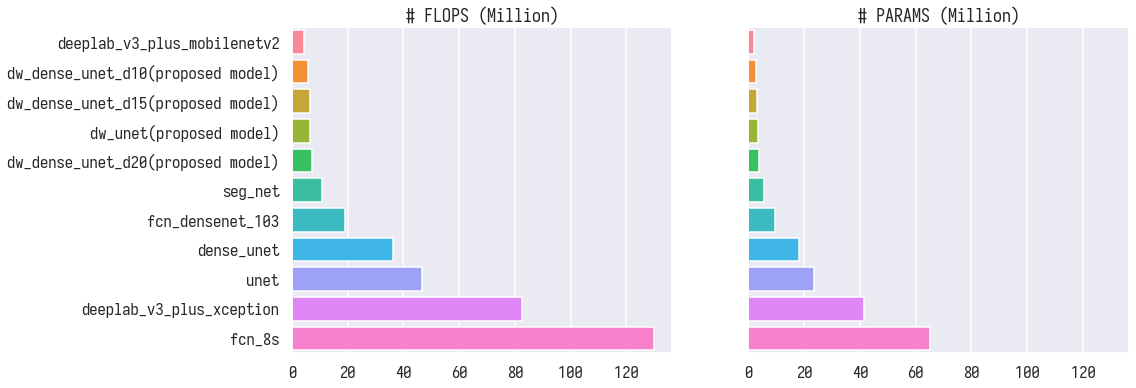

In [2]:
df = pd.read_csv("flops.csv")
df = df.sort_values(by=['flops'])
cols = ['flops', 'params']

fig, axis = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
sns.set_style('darkgrid', {'font.sans-serif': ['Iosevka']})

for (ax, col) in zip(axis, cols):
    barplot = sns.barplot(ax=ax, y=df.model, x=df[col], saturation=1)
    ax.set_title(f'# {col.upper()} (Million)', fontdict={'size': 18})
    ax.set_xlabel('')
    ax.set_ylabel('')

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Learning curves</h2>
</div>

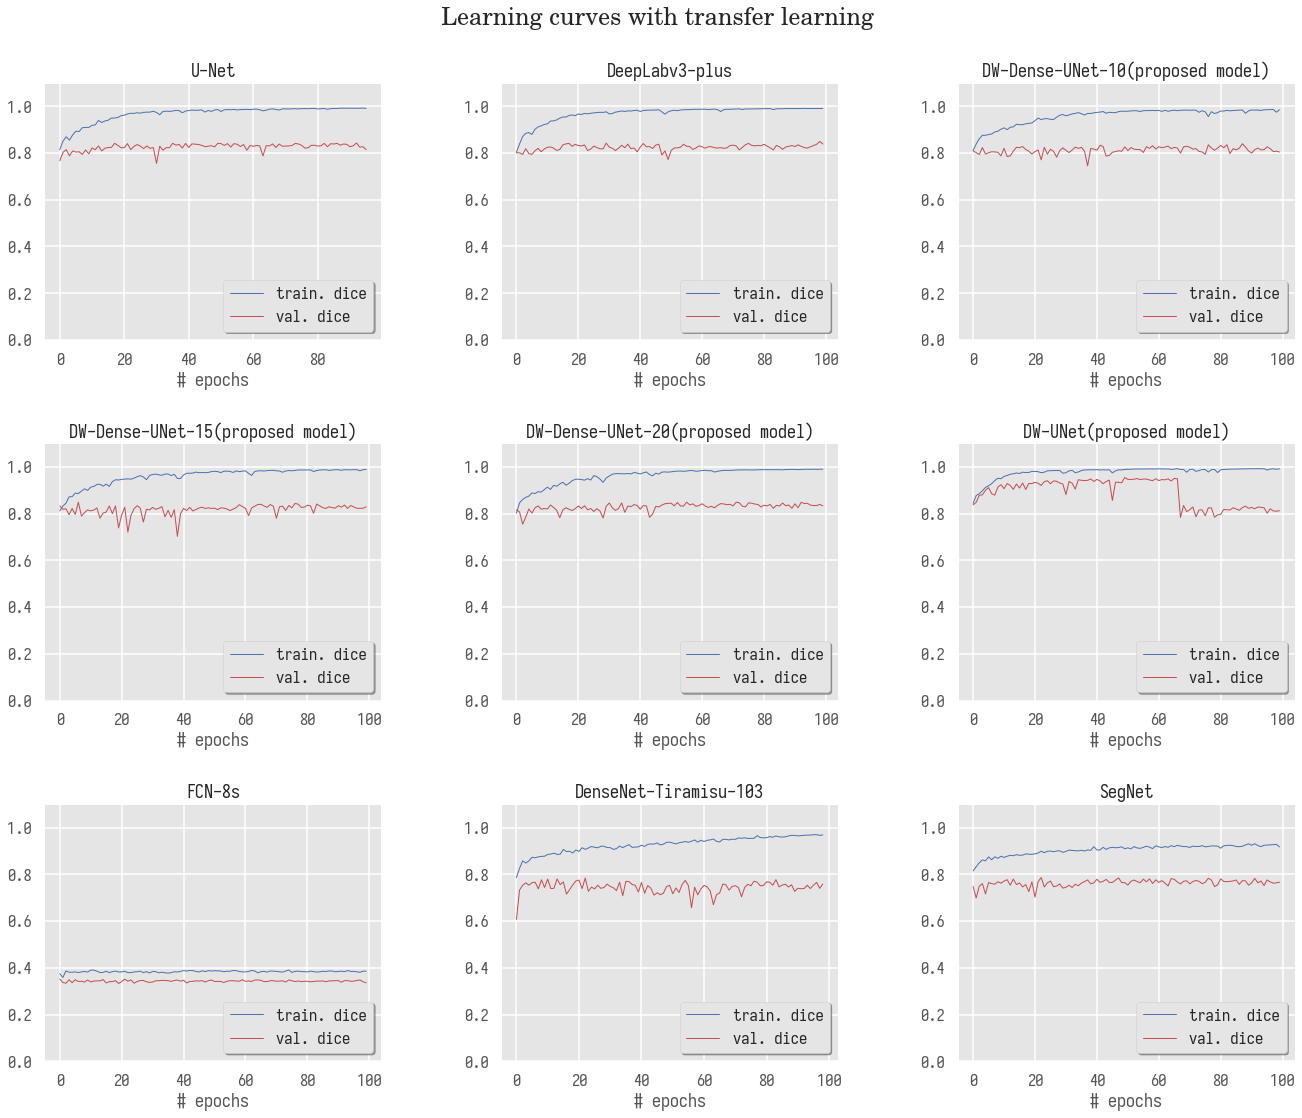

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.titlesize'] = 24
ft = {'family': 'Iosevka', 'size': 18}


score_file_lst = {
    'U-Net': 'road_seg_nit_unet_default_320_320_weights_21_05_20-00_59_AM.csv',
    'DeepLabv3-plus': 'road_seg_nit_deeplab_v3_plus_xception_320_320_weights_22_05_20-07_38_AM.csv',
    'DW-Dense-UNet-10(proposed model)': 'road_seg_nit_dw_dense_unet_d10_default_320_320_weights_19_05_20-17_03_PM.csv',
    'DW-Dense-UNet-15(proposed model)': 'road_seg_nit_dw_dense_unet_d15_default_320_320_weights_19_05_20-22_24_PM.csv',
    'DW-Dense-UNet-20(proposed model)': 'road_seg_nit_dw_dense_unet_d20_default_320_320_weights_20_05_20-08_14_AM.csv',
    'DW-UNet(proposed model)' : 'road_seg_nit_dw_unet_default_320_320_weights_18_05_20-03_25_AM.csv',
    'FCN-8s': 'road_seg_nit_fcn_8s_default_320_320_weights_20_05_20-15_57_PM.csv',
    'DenseNet-Tiramisu-103': 'road_seg_nit_fcn_densenet_103_vgg16_320_320_weights_21_05_20-11_09_AM.csv',
    'SegNet': 'road_seg_nit_seg_net_default_320_320_weights_20_05_20-19_05_PM.csv'
}

fig, axes = plt.subplots(3, 3, figsize=(20,16))
fig.tight_layout(pad=7.0)

plt.suptitle('Learning curves with transfer learning', va='bottom', fontdict={'family': 'C059'})

for ax, (model, path) in zip(axes.flatten(), score_file_lst.items()): 
    scores = pd.read_csv(f"training score/{path}")
    ax.plot(scores['dice'], 'b', label='train. dice')
    ax.plot(scores['val_dice'], 'r', label='val. dice')
    ax.set_title(f'{model}', fontdict=ft)
    ax.set_xlabel('# epochs', fontdict=ft)
    ax.set_ylim([0,1.1])
    ax.legend(loc='lower right', shadow=True)  
    del scores

del ft, fig, axes, score_file_lst

<link href="https://fonts.googleapis.com/css2?family=Fira+Sans+Condensed&display=swap" rel="stylesheet">

<div style="font-family:'Fira Sans Condensed';font-size:18px;">
<h2>Prediction outcome</h2>
</div>

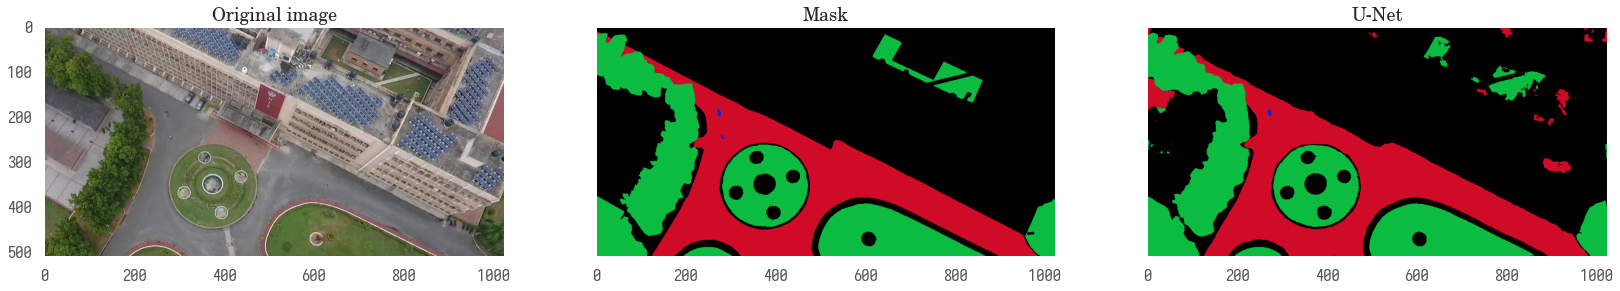

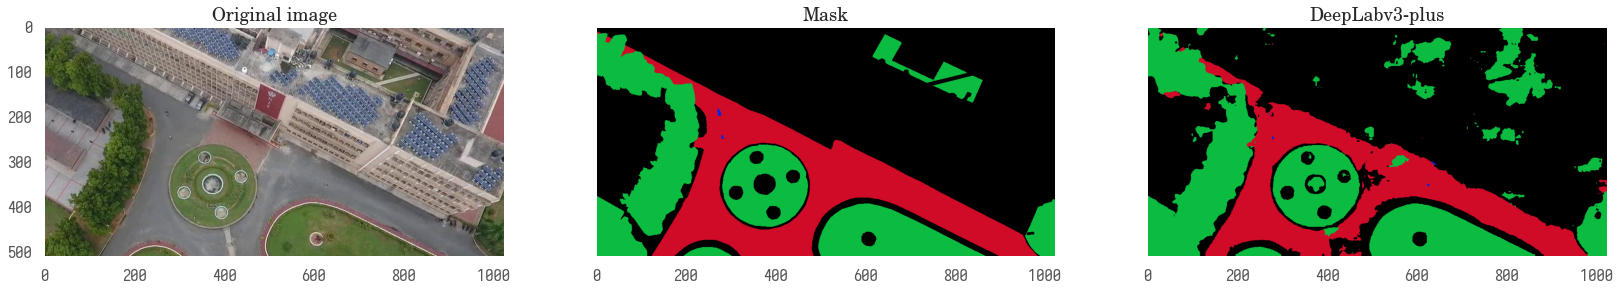

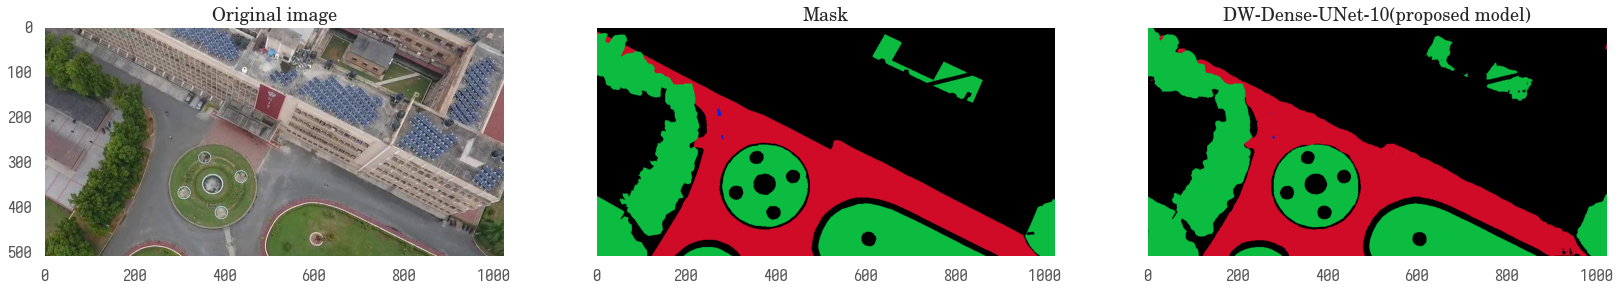

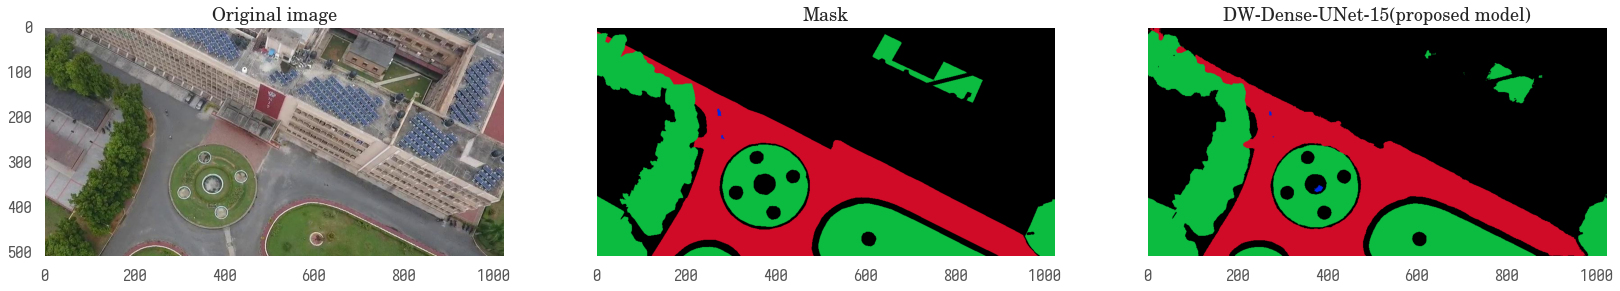

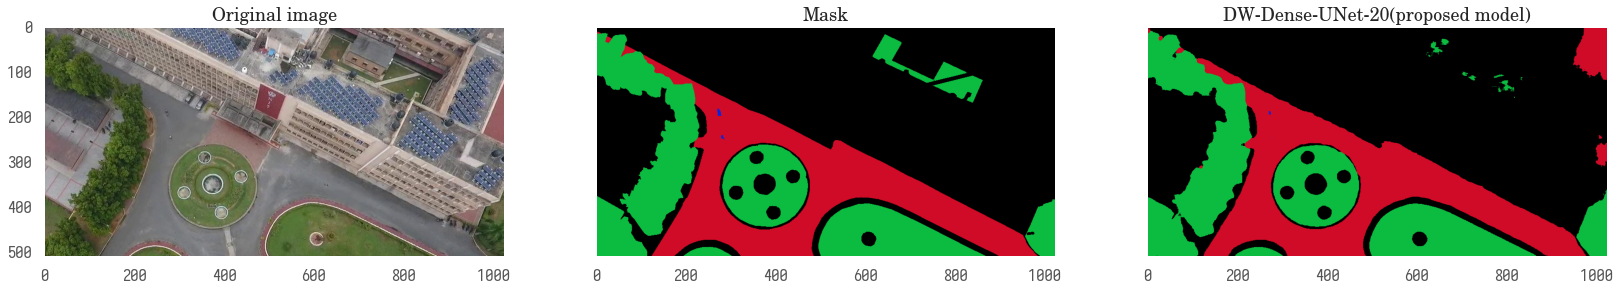

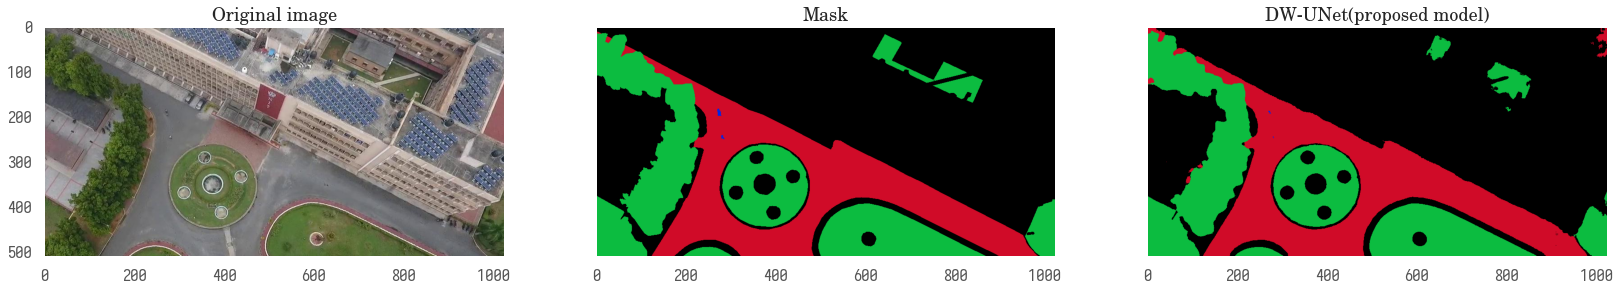

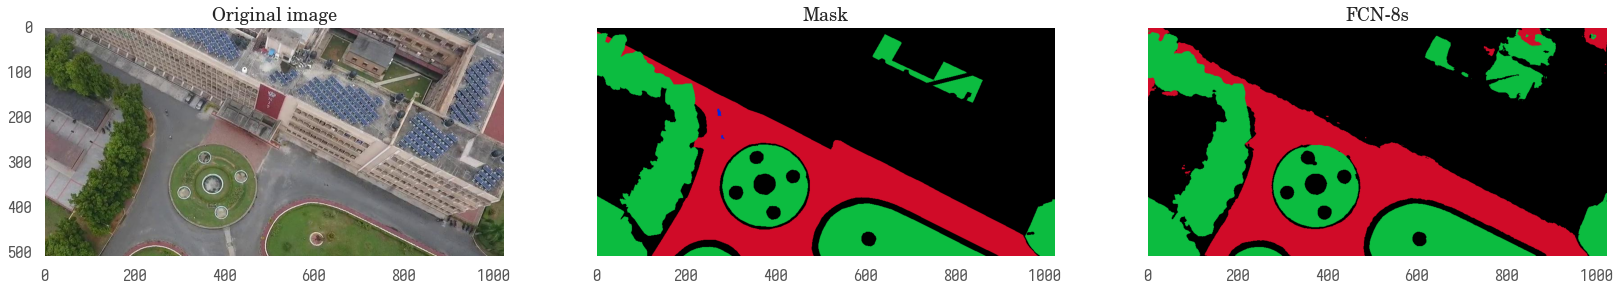

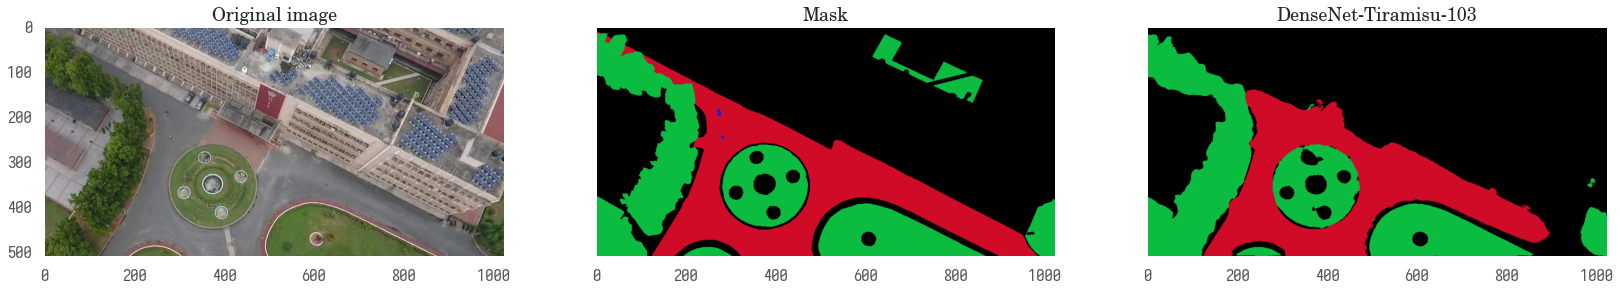

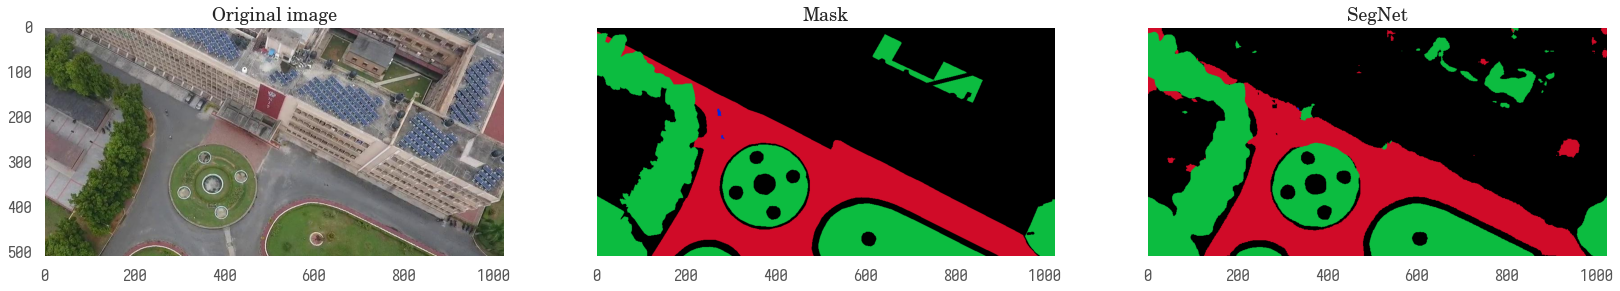

In [4]:
ft = {'family': 'C059', 'size': 18}

img_file_lst = {
    'U-Net': 'U-Net.png',
    'DeepLabv3-plus': 'DeepLabV3 -plus.png',
    'DW-Dense-UNet-10(proposed model)': 'DW-Dense-UNet-10.png',
    'DW-Dense-UNet-15(proposed model)': 'DW-Dense-UNet-15.png',
    'DW-Dense-UNet-20(proposed model)': 'DW-Dense-UNet-20.png',
    'DW-UNet(proposed model)' : 'DW-UNet.png',
    'FCN-8s': 'FCN-8s.png',
    'DenseNet-Tiramisu-103': 'DenseNet-Tiramisu-103.png',
    'SegNet': 'SegNet.png'
}


def visualize(frame, mask, prediction, model):
    f, ax = plt.subplots(1, 3, figsize=(28, 20), sharey=True)
    ax[0].imshow(frame)
    ax[0].set_title(f'Original image', fontdict=ft)
    ax[0].grid(False)

    ax[1].imshow(mask)
    ax[1].set_title(f'Mask', fontdict=ft)
    ax[1].grid(False)

    ax[2].imshow(prediction)
    ax[2].set_title(f'{model}', fontdict=ft)
    ax[2].grid(False)


    
for model, path in img_file_lst.items():
    frame = mpimg.imread(f'samples/Frame.png')
    mask = mpimg.imread(f'samples/Mask.png')
    prediction = mpimg.imread(f'samples/{path}')
    
    visualize(frame, mask, prediction, model)
    
    del frame, mask, prediction
